# Identifying Differentially Expressed Genes as part of progeny Pathways per celltype using scvi and pyDeseq2
- Created by: Christian Eger
- Creation date: October 14, 2024
- environment: liana_c2c-env.yml

## Control Flow

In [2]:
cell_type_key = "cell_compartment" # The key for the celltype annotation you want to use in adata.obs
batch_key = "batch" # The batch key used for pseudobulking along for pyDESeq and for batch integration for scvi
design_factor = "infection" # The key for the experimental conditions you want to test for in adata.obs
design_values = ("CTRL", "IAV") # Two of the values found in the design_factor and only two

## Environment Setup

In [3]:
from pathlib import Path
import pandas as pd
import scvi
import decoupler
import scanpy as sc
import anndata as ad
from scipy import sparse
from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats
from typing import Iterable, Iterator
from functools import reduce
from itertools import combinations, chain

/home/ceger/miniforge3/envs/scvi_and_pydeseq-env/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/ceger/miniforge3/envs/scvi_and_pydeseq-env/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/ceger/miniforge3/envs/scvi_and_pydeseq-env/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
/home/ceger/miniforge3/envs/scvi_and_pydeseq-env/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing CSCDataset from `anndata.experimental` is deprecated. Import anndata.abc.CSCDataset instead.
  warnings.warn(msg, FutureWarning)
/home/ceger/miniforge3/envs/scvi_a

### Helper Functions

In [24]:
def generate_adata_subsets(adata: ad.AnnData, layer: str, key: str, values: Iterable) -> Iterator[ad.AnnData]:
    """Takes an AnnData Object and returns an iterable of AnnData Objects subset for their values in a column in either .obs or .var"""
    return (adata[getattr(adata, layer)[key] == value] for value in values)

def pseudobulk_from_adata(adata: ad.AnnData) -> ad.AnnData:
    """
    Takes an AnnData Object with n_obs x n_vars and returns an AnnData object with 1 obs x n_vars by summing along the obs dimension.
    Metadata for observations is kept, if in the original AnnData object only a single value was stored.
    """
    return ad.AnnData(
        X=sparse.csr_matrix(adata.X.toarray().sum(axis=0)),
        obs=adata.obs[filter(lambda column: len(set(adata.obs[column])) == 1, adata.obs.columns)].head(1),
        var=adata.var
    )

def run_deseq_DEG(adata: ad.AnnData, design_factor: str, inference=DefaultInference(n_cpus=8)) -> pd.DataFrame:
    """Wrapper function for pyDESeq differentially expressed gene analysis"""
    dds = DeseqDataSet(
        counts=pd.DataFrame(adata.X.toarray(), index=adata.obs_names, columns=adata.var_names),
        metadata=adata.obs,
        design_factors=design_factor,
        refit_cooks=True,
        inference=inference,
    )
    dds.deseq2()
    result = DeseqStats(dds, alpha=0.05, cooks_filter=True, independent_filter=True)
    result.summary()
    return result.results_df

def run_scvi_DEG(adata: ad.AnnData, batch_key: str, design_factor: str, design_values: tuple[str]):
    """Wrapper function for scvi differentially expressed gene analysis"""
    adata = adata.copy()
    scvi.model.SCVI.setup_anndata(
        adata,
        batch_key=batch_key
    )
    vae = scvi.model.SCVI(adata)
    vae.train()
    return vae.differential_expression(groupby=design_factor, group1=design_values[0], group2=design_values[1])

def powerset(iterable):
    """powerset([1,2,3]) → (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"""
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(1, len(s)+1))

def powerset_modified(iterable):
    """Same as powerset, but without the combinations between 1 and n"""
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in (1, len(s)))


### Folder Structure

In [5]:
global_repo_data = Path.cwd() / ".." / ".." / ".data"
local_folder_data = Path.cwd() / ".data"
figures_dir = local_folder_data / "figures"

### Data Loading

In [6]:
adata = sc.read_h5ad(global_repo_data / "Marburg_cell_states_locked_ctl240709.raw.h5ad")
adata

AnnData object with n_obs × n_vars = 97573 × 27208
    obs: 'sex', 'age', 'ethnicity', 'PaCO2', 'donor', 'infection', 'disease', 'SMK', 'illumina_stimunr', 'bd_rhapsody', 'n_genes', 'doublet_scores', 'predicted_doublets', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'condition', 'sample_group', 'IAV_score', 'group', 'Viral_score', 'cell_type', 'cell_states', 'leiden', 'cell_compartment', '_scvi_batch', '_scvi_labels', 'C_scANVI', 'viral_counts', 'infected_status', 'seed_labels', 'batch-scANVI'
    var: 'mt', 'ribo'
    uns: 'cell_compartment_colors', 'cell_states_colors', 'disease_colors', 'group_colors', 'infection_colors'
    obsm: 'X_scANVI', 'X_umap'

In [7]:
# Necessary to filter the celltypes for the ones that appear in both experimental conditions
cell_types = reduce(set.intersection, (set(adata.obs[cell_type_key]) for adata in  generate_adata_subsets(adata, "obs", design_factor, design_values))) - {"Epi"}
#cell_types = cell_types[:3]
cell_types

{'Basal',
 'Ciliated',
 'Club',
 'Deuterosomal',
 'Goblet',
 'Ionocyte',
 'Mixed',
 'Secretory',
 'SupraB'}

In [8]:
net = decoupler.get_progeny(organism='human')
net

,source,target,weight,p_value
0,Androgen,TMPRSS2,11.490631,0.000000e+00
1,Androgen,NKX3-1,10.622551,2.242078e-44
2,Androgen,MBOAT2,10.472733,4.624285e-44
3,Androgen,KLK2,10.176186,1.944414e-40
4,Androgen,SARG,11.386852,2.790209e-40
...,...,...,...,...
1395,p53,CCDC150,-3.174527,7.396252e-13
1396,p53,LCE1A,6.154823,8.475458e-13
1397,p53,TREM2,4.101937,9.739648e-13
1398,p53,GDF9,3.355741,1.087433e-12


## Run DEG analyses

### pyDESeq

In [9]:
"""
Running pyDESeq on pseudobulks along samples for each celltype 
"""
pyDESeq_res_dict = {cell_type: run_deseq_DEG(sc.concat((pseudobulk_from_adata(adata) for adata in generate_adata_subsets(adata, "obs", batch_key, set(adata.obs[batch_key])))), design_factor=design_factor) 
                    for cell_type, adata 
                    in zip(cell_types, generate_adata_subsets(adata, "obs", cell_type_key, cell_types))}
pyDESeq_res_dict

Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 2.10 seconds.

Fitting dispersion trend curve...
... done in 0.40 seconds.

Fitting MAP dispersions...
... done in 2.36 seconds.

Fitting LFCs...
... done in 1.83 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 84 outlier genes.

Fitting dispersions...
... done in 0.03 seconds.

Fitting MAP dispersions...
... done in 0.03 seconds.

Fitting LFCs...
... done in 0.03 seconds.

Running Wald tests...
... done in 6.28 seconds.



Log2 fold change & Wald test p-value: infection IAV vs CTRL
             baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG         5.023295        1.084627  0.637237  1.702076  0.088741  0.854060
A1BG-AS1     4.363166       -0.035758  0.557402 -0.064151  0.948850  0.999691
A1CF         2.203427        0.300725  0.582807  0.515994  0.605858  0.999691
A2M          1.776101        0.628148  0.627067  1.001724  0.316477  0.999691
A2M-AS1      4.769323        0.572810  0.427420  1.340157  0.180194  0.999691
...               ...             ...       ...       ...       ...       ...
ZXDC       638.772218        0.046782  0.260810  0.179374  0.857644  0.999691
ZYG11A       8.312618        0.271357  0.388568  0.698351  0.484958  0.999691
ZYG11B     822.924209       -0.061140  0.090568 -0.675067  0.499633  0.999691
ZYX       5263.483709        0.194556  0.145978  1.332779  0.182604  0.999691
ZZEF1      311.960007       -0.190763  0.149142 -1.279067  0.200873  0.999691

[27

Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 1.46 seconds.

Fitting dispersion trend curve...
/home/ceger/miniforge3/envs/scvi_and_pydeseq-env/lib/python3.10/site-packages/pydeseq2/dds.py:727: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.33 seconds.

Fitting MAP dispersions...
... done in 2.54 seconds.

Fitting LFCs...
... done in 1.88 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 63 outlier genes.

Fitting dispersions...
... done in 0.03 seconds.

Fitting MAP dispersions...
... done in 0.03 seconds.

Fitting LFCs...
... done in 0.04 seconds.

Running Wald tests...
... done in 6.08 seconds.



Log2 fold change & Wald test p-value: infection IAV vs CTRL
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        0.813347        1.387454  1.237998  1.120724  0.262405       NaN
A1BG-AS1    0.374187        0.299346  1.184631  0.252691  0.800507       NaN
A1CF        0.246009        0.617131  0.906924  0.680466  0.496209       NaN
A2M         2.504054        2.241828  1.733698  1.293090  0.195980  0.999863
A2M-AS1     0.435050        2.600090  0.857662  3.031603  0.002433       NaN
...              ...             ...       ...       ...       ...       ...
ZXDC       98.060536       -0.097126  0.302944 -0.320608  0.748507  0.999863
ZYG11A      1.270519        0.668226  0.805349  0.829735  0.406689       NaN
ZYG11B    151.646367        0.091609  0.139216  0.658036  0.510515  0.999863
ZYX       801.720054        0.089909  0.192256  0.467654  0.640032  0.999863
ZZEF1      55.051011        0.308358  0.240017  1.284733  0.198885  0.999863

[27208 rows x 6

Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 1.68 seconds.

Fitting dispersion trend curve...
... done in 0.33 seconds.

Fitting MAP dispersions...
... done in 1.76 seconds.

Fitting LFCs...
... done in 1.65 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 53 outlier genes.

Fitting dispersions...
... done in 0.02 seconds.

Fitting MAP dispersions...
... done in 0.02 seconds.

Fitting LFCs...
... done in 0.03 seconds.

Running Wald tests...
... done in 6.41 seconds.



Log2 fold change & Wald test p-value: infection IAV vs CTRL
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        0.720590        1.229423  1.635099  0.751895  0.452114  0.999978
A1BG-AS1    0.068577        1.109953  3.181568  0.348870  0.727187  0.999978
A1CF        0.173123        0.946528  1.660349  0.570078  0.568625  0.999978
A2M         0.041330        0.879779  3.204032  0.274585  0.783635  0.999978
A2M-AS1     0.334043        0.647190  1.821857  0.355237  0.722412  0.999978
...              ...             ...       ...       ...       ...       ...
ZXDC       62.234127       -0.192122  0.273432 -0.702633  0.482285  0.999978
ZYG11A      2.100584       -0.674103  0.750040 -0.898756  0.368783  0.999978
ZYG11B    104.230227       -0.050295  0.126919 -0.396277  0.691901  0.999978
ZYX       900.189226        0.198638  0.123280  1.611270  0.107121  0.999978
ZZEF1      31.018945       -0.003731  0.297793 -0.012530  0.990003  0.999978

[27208 rows x 6

Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 1.74 seconds.

Fitting dispersion trend curve...
... done in 0.39 seconds.

Fitting MAP dispersions...
... done in 1.97 seconds.

Fitting LFCs...
... done in 1.54 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 58 outlier genes.

Fitting dispersions...
... done in 0.02 seconds.

Fitting MAP dispersions...
... done in 0.02 seconds.

Fitting LFCs...
... done in 0.02 seconds.

Running Wald tests...
... done in 6.49 seconds.



Log2 fold change & Wald test p-value: infection IAV vs CTRL
             baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG         6.407500        0.081481  0.440084  0.185150  0.853112  0.999827
A1BG-AS1     7.549312        0.434621  0.469433  0.925843  0.354528  0.999827
A1CF         1.391567        0.410691  0.732707  0.560512  0.575130       NaN
A2M          1.336662        0.171709  0.842291  0.203859  0.838464       NaN
A2M-AS1      1.762690       -0.404276  1.157526 -0.349259  0.726895       NaN
...               ...             ...       ...       ...       ...       ...
ZXDC       303.048274       -0.126939  0.209727 -0.605255  0.545010  0.999827
ZYG11A       5.747619       -0.069552  0.439280 -0.158332  0.874196  0.999827
ZYG11B     418.438820        0.033324  0.098584  0.338029  0.735341  0.999827
ZYX       8913.152916        0.073453  0.143129  0.513192  0.607817  0.999827
ZZEF1      122.925018       -0.051008  0.194214 -0.262639  0.792829  0.999827

[27

Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 1.73 seconds.

Fitting dispersion trend curve...
... done in 0.47 seconds.

Fitting MAP dispersions...
... done in 1.98 seconds.

Fitting LFCs...
... done in 1.44 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 222 outlier genes.

Fitting dispersions...
... done in 0.06 seconds.

Fitting MAP dispersions...
... done in 0.05 seconds.

Fitting LFCs...
... done in 0.05 seconds.

Running Wald tests...
... done in 6.84 seconds.



Log2 fold change & Wald test p-value: infection IAV vs CTRL
             baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG         1.868333       -0.210345  0.787589 -0.267075  0.789411  0.901827
A1BG-AS1     2.978886        0.031273  0.611672  0.051127  0.959224  0.982866
A1CF         1.114878        1.159180  0.914158  1.268031  0.204787       NaN
A2M          1.010612        1.981755  1.124893  1.761728  0.078115       NaN
A2M-AS1      2.672943       -1.137740  0.665959 -1.708422  0.087558  0.280070
...               ...             ...       ...       ...       ...       ...
ZXDC       181.109286       -0.122915  0.217507 -0.565109  0.571999  0.775067
ZYG11A       5.322446        0.079892  0.528672  0.151119  0.879882  0.947180
ZYG11B     276.188644       -0.070378  0.082209 -0.856091  0.391947  0.643079
ZYX       2095.078202       -0.218343  0.164789 -1.324986  0.185176  0.432122
ZZEF1      100.426380        0.214855  0.208866  1.028672  0.303634  0.563261

[27

Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 1.82 seconds.

Fitting dispersion trend curve...
... done in 0.38 seconds.

Fitting MAP dispersions...
... done in 2.35 seconds.

Fitting LFCs...
... done in 1.92 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 69 outlier genes.

Fitting dispersions...
... done in 0.03 seconds.

Fitting MAP dispersions...
... done in 0.03 seconds.

Fitting LFCs...
... done in 0.03 seconds.

Running Wald tests...
... done in 6.42 seconds.



Log2 fold change & Wald test p-value: infection IAV vs CTRL
              baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG         67.872999       -0.049607  0.333036 -0.148953  0.881591  0.999994
A1BG-AS1     61.526260       -0.132335  0.369295 -0.358346  0.720085  0.999994
A1CF          4.833093       -0.292701  0.349321 -0.837913  0.402080  0.999994
A2M           8.966189       -0.106772  0.589066 -0.181257  0.856166  0.999994
A2M-AS1       8.968806        0.115844  0.389683  0.297277  0.766255  0.999994
...                ...             ...       ...       ...       ...       ...
ZXDC       1086.672881        0.042552  0.203487  0.209113  0.834360  0.999994
ZYG11A        9.150713        0.161512  0.285407  0.565903  0.571460  0.999994
ZYG11B     1564.356332       -0.081312  0.047336 -1.717774  0.085838  0.999994
ZYX       24219.479929        0.049483  0.155643  0.317926  0.750541  0.999994
ZZEF1       434.620918       -0.076179  0.186057 -0.409440  0.682217  0

Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 1.29 seconds.

Fitting dispersion trend curve...
... done in 0.43 seconds.

Fitting MAP dispersions...
... done in 1.39 seconds.

Fitting LFCs...
... done in 1.41 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 85 outlier genes.

Fitting dispersions...
... done in 0.03 seconds.

Fitting MAP dispersions...
... done in 0.03 seconds.

Fitting LFCs...
... done in 0.04 seconds.

Running Wald tests...
... done in 6.65 seconds.



Log2 fold change & Wald test p-value: infection IAV vs CTRL
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.172133        1.227584  3.113883  0.394229  0.693412       NaN
A1BG-AS1   0.314490        0.486121  2.158746  0.225187  0.821834  0.999832
A1CF       0.071661        0.055175  3.188275  0.017306  0.986193       NaN
A2M        0.015034        0.036579  3.189964  0.011467  0.990851       NaN
A2M-AS1    0.220616        1.291838  2.620988  0.492882  0.622096  0.999832
...             ...             ...       ...       ...       ...       ...
ZXDC      15.944070        0.180115  0.376873  0.477920  0.632707  0.999832
ZYG11A     0.491274       -2.568882  1.969136 -1.304573  0.192038  0.999832
ZYG11B    30.165433        0.047640  0.216158  0.220393  0.825565  0.999832
ZYX       94.458246        0.101182  0.120444  0.840075  0.400866  0.999832
ZZEF1      6.221523        0.108399  0.444994  0.243597  0.807543  0.999832

[27208 rows x 6 columns]


Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 1.39 seconds.

Fitting dispersion trend curve...
... done in 0.35 seconds.

Fitting MAP dispersions...
... done in 1.43 seconds.

Fitting LFCs...
... done in 1.64 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 46 outlier genes.

Fitting dispersions...
... done in 0.02 seconds.

Fitting MAP dispersions...
... done in 0.02 seconds.

Fitting LFCs...
... done in 0.02 seconds.

Running Wald tests...
... done in 6.60 seconds.



Log2 fold change & Wald test p-value: infection IAV vs CTRL
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.159330        0.292358  2.445586  0.119545  0.904843       NaN
A1BG-AS1   0.477610       -0.582874  1.173521 -0.496688  0.619409       NaN
A1CF       0.000000             NaN       NaN       NaN       NaN       NaN
A2M        0.008159        1.218334  3.224669  0.377817  0.705567       NaN
A2M-AS1    0.118724        1.296554  2.640370  0.491050  0.623391       NaN
...             ...             ...       ...       ...       ...       ...
ZXDC      16.686830        0.113282  0.361963  0.312966  0.754306  0.999282
ZYG11A     0.620965        0.035243  1.056258  0.033366  0.973383       NaN
ZYG11B    12.747118        0.226836  0.349848  0.648385  0.516736  0.999282
ZYX       22.268654       -0.319533  0.260260 -1.227746  0.219542  0.999282
ZZEF1      5.935900        0.110330  0.496055  0.222415  0.823991  0.999282

[27208 rows x 6 columns]


Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 1.65 seconds.

Fitting dispersion trend curve...
... done in 0.45 seconds.

Fitting MAP dispersions...
... done in 1.80 seconds.

Fitting LFCs...
... done in 1.77 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 96 outlier genes.

Fitting dispersions...
... done in 0.04 seconds.

Fitting MAP dispersions...
... done in 0.04 seconds.

Fitting LFCs...
... done in 0.05 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value: infection IAV vs CTRL
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        8.815644       -0.156242  0.425909 -0.366845  0.713735  0.999727
A1BG-AS1   25.221849        0.198882  0.298950  0.665268  0.505879  0.999727
A1CF        0.567112        1.301962  1.241685  1.048544  0.294388       NaN
A2M         0.119846        0.390767  2.819214  0.138608  0.889760       NaN
A2M-AS1     1.352156       -0.818859  0.800958 -1.022349  0.306616  0.999727
...              ...             ...       ...       ...       ...       ...
ZXDC       97.482790       -0.184844  0.257336 -0.718297  0.472574  0.999727
ZYG11A      3.221048       -1.056853  0.622507 -1.697737  0.089557  0.999727
ZYG11B     83.818042       -0.076613  0.136153 -0.562695  0.573642  0.999727
ZYX       293.473960       -0.076318  0.196689 -0.388012  0.698007  0.999727
ZZEF1      42.658418       -0.180074  0.237324 -0.758767  0.447992  0.999727

[27208 rows x 6

... done in 6.73 seconds.



{'Goblet':              baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
 A1BG         5.023295        1.084627  0.637237  1.702076  0.088741  0.854060
 A1BG-AS1     4.363166       -0.035758  0.557402 -0.064151  0.948850  0.999691
 A1CF         2.203427        0.300725  0.582807  0.515994  0.605858  0.999691
 A2M          1.776101        0.628148  0.627067  1.001724  0.316477  0.999691
 A2M-AS1      4.769323        0.572810  0.427420  1.340157  0.180194  0.999691
 ...               ...             ...       ...       ...       ...       ...
 ZXDC       638.772218        0.046782  0.260810  0.179374  0.857644  0.999691
 ZYG11A       8.312618        0.271357  0.388568  0.698351  0.484958  0.999691
 ZYG11B     822.924209       -0.061140  0.090568 -0.675067  0.499633  0.999691
 ZYX       5263.483709        0.194556  0.145978  1.332779  0.182604  0.999691
 ZZEF1      311.960007       -0.190763  0.149142 -1.279067  0.200873  0.999691
 
 [27208 rows x 6 columns],
 'Mixed':    

### scvi

In [10]:
## temp for debugging
#scvi_res_dict = {}
#for celltype, adata in zip(cell_types, generate_adata_subsets(adata, "obs", cell_type_key, cell_types)):
#    print(celltype)
#    scvi_res_dict[celltype] = run_scvi_DEG(adata, batch_key=batch_key, design_factor=design_factor, design_values=design_values) 
#scvi_res_dict

In [11]:
#"""
#Running scvi differential expression for each celltype
#"""
#scvi_res_dict = {cell_type: run_scvi_DEG(adata, batch_key=batch_key, design_factor=design_factor, design_values=design_values) 
#                 for cell_type, adata 
#                 in zip(cell_types, generate_adata_subsets(adata, "obs", cell_type_key, cell_types))}
#scvi_res_dict

In [12]:
pyDESeq_res_dict.keys()

dict_keys(['Goblet', 'Mixed', 'Secretory', 'SupraB', 'Club', 'Basal', 'Ionocyte', 'Deuterosomal', 'Ciliated'])

In [13]:
list(powerset(cell_types))

[('Goblet',),
 ('Mixed',),
 ('Secretory',),
 ('SupraB',),
 ('Club',),
 ('Basal',),
 ('Ionocyte',),
 ('Deuterosomal',),
 ('Ciliated',),
 ('Goblet', 'Mixed'),
 ('Goblet', 'Secretory'),
 ('Goblet', 'SupraB'),
 ('Goblet', 'Club'),
 ('Goblet', 'Basal'),
 ('Goblet', 'Ionocyte'),
 ('Goblet', 'Deuterosomal'),
 ('Goblet', 'Ciliated'),
 ('Mixed', 'Secretory'),
 ('Mixed', 'SupraB'),
 ('Mixed', 'Club'),
 ('Mixed', 'Basal'),
 ('Mixed', 'Ionocyte'),
 ('Mixed', 'Deuterosomal'),
 ('Mixed', 'Ciliated'),
 ('Secretory', 'SupraB'),
 ('Secretory', 'Club'),
 ('Secretory', 'Basal'),
 ('Secretory', 'Ionocyte'),
 ('Secretory', 'Deuterosomal'),
 ('Secretory', 'Ciliated'),
 ('SupraB', 'Club'),
 ('SupraB', 'Basal'),
 ('SupraB', 'Ionocyte'),
 ('SupraB', 'Deuterosomal'),
 ('SupraB', 'Ciliated'),
 ('Club', 'Basal'),
 ('Club', 'Ionocyte'),
 ('Club', 'Deuterosomal'),
 ('Club', 'Ciliated'),
 ('Basal', 'Ionocyte'),
 ('Basal', 'Deuterosomal'),
 ('Basal', 'Ciliated'),
 ('Ionocyte', 'Deuterosomal'),
 ('Ionocyte', 'Ciliated

## Plotting

In [47]:
pyDESeq_res_dict["Basal"].sort_values(["log2FoldChange"], ascending=False)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
CXCL11,6019.979554,6.255021,0.466829,13.398953,6.132200e-41,4.852684e-38
CXCL9,539.090125,5.979505,0.519324,11.514012,1.121377e-30,5.045979e-28
CXCL10,9730.891122,5.956589,0.521503,11.421962,3.248168e-30,1.406457e-27
RSAD2,5460.132291,5.599640,0.361939,15.471228,5.426158e-54,7.782806e-51
IFIT1,20031.666554,5.349627,0.266150,20.100035,7.374196e-90,1.692304e-85
...,...,...,...,...,...,...
PRAP1,0.000000,NaN,NaN,NaN,NaN,NaN
PROP1,0.000000,NaN,NaN,NaN,NaN,NaN
ROPN1L-AS1,0.000000,NaN,NaN,NaN,NaN,NaN
TMEM247,0.000000,NaN,NaN,NaN,NaN,NaN


In [101]:
test = [(celltype_set, len(reduce(set.intersection, (set(pyDESeq_res_dict[cell_type].query("pvalue < 0.05 and log2FoldChange > 4").index) for cell_type in celltype_set)))) for celltype_set in powerset(cell_types)]
test

[(('Goblet',), 21),
 (('Mixed',), 5),
 (('Secretory',), 1),
 (('SupraB',), 13),
 (('Club',), 86),
 (('Basal',), 22),
 (('Ionocyte',), 0),
 (('Deuterosomal',), 13),
 (('Ciliated',), 23),
 (('Goblet', 'Mixed'), 0),
 (('Goblet', 'Secretory'), 0),
 (('Goblet', 'SupraB'), 11),
 (('Goblet', 'Club'), 17),
 (('Goblet', 'Basal'), 15),
 (('Goblet', 'Ionocyte'), 0),
 (('Goblet', 'Deuterosomal'), 10),
 (('Goblet', 'Ciliated'), 8),
 (('Mixed', 'Secretory'), 0),
 (('Mixed', 'SupraB'), 0),
 (('Mixed', 'Club'), 0),
 (('Mixed', 'Basal'), 0),
 (('Mixed', 'Ionocyte'), 0),
 (('Mixed', 'Deuterosomal'), 0),
 (('Mixed', 'Ciliated'), 0),
 (('Secretory', 'SupraB'), 0),
 (('Secretory', 'Club'), 0),
 (('Secretory', 'Basal'), 0),
 (('Secretory', 'Ionocyte'), 0),
 (('Secretory', 'Deuterosomal'), 0),
 (('Secretory', 'Ciliated'), 0),
 (('SupraB', 'Club'), 12),
 (('SupraB', 'Basal'), 13),
 (('SupraB', 'Ionocyte'), 0),
 (('SupraB', 'Deuterosomal'), 7),
 (('SupraB', 'Ciliated'), 3),
 (('Club', 'Basal'), 17),
 (('Club',

In [102]:
cell_type_combinations = []
data = []
for celltype_set, d in test:
    if d > 0:
        cell_type_combinations.append(list(celltype_set))
        data.append(d)

In [103]:
from upsetplot import from_memberships
example = from_memberships(cell_type_combinations, data)

In [104]:
example

Basal  Ciliated  Club   Deuterosomal  Goblet  Mixed  Secretory  SupraB
False  False     False  False         True    False  False      False     21
                                      False   True   False      False      5
                                              False  True       False      1
                                                     False      True      13
                 True   False         False   False  False      False     86
                                                                          ..
       True      True   True          True    False  False      True       3
True   True      False  True          True    False  False      True       3
                 True   True          True    False  False      False      5
                                      False   False  False      True       3
                                      True    False  False      True       3
Length: 65, dtype: int64

In [105]:
import upsetplot

{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}

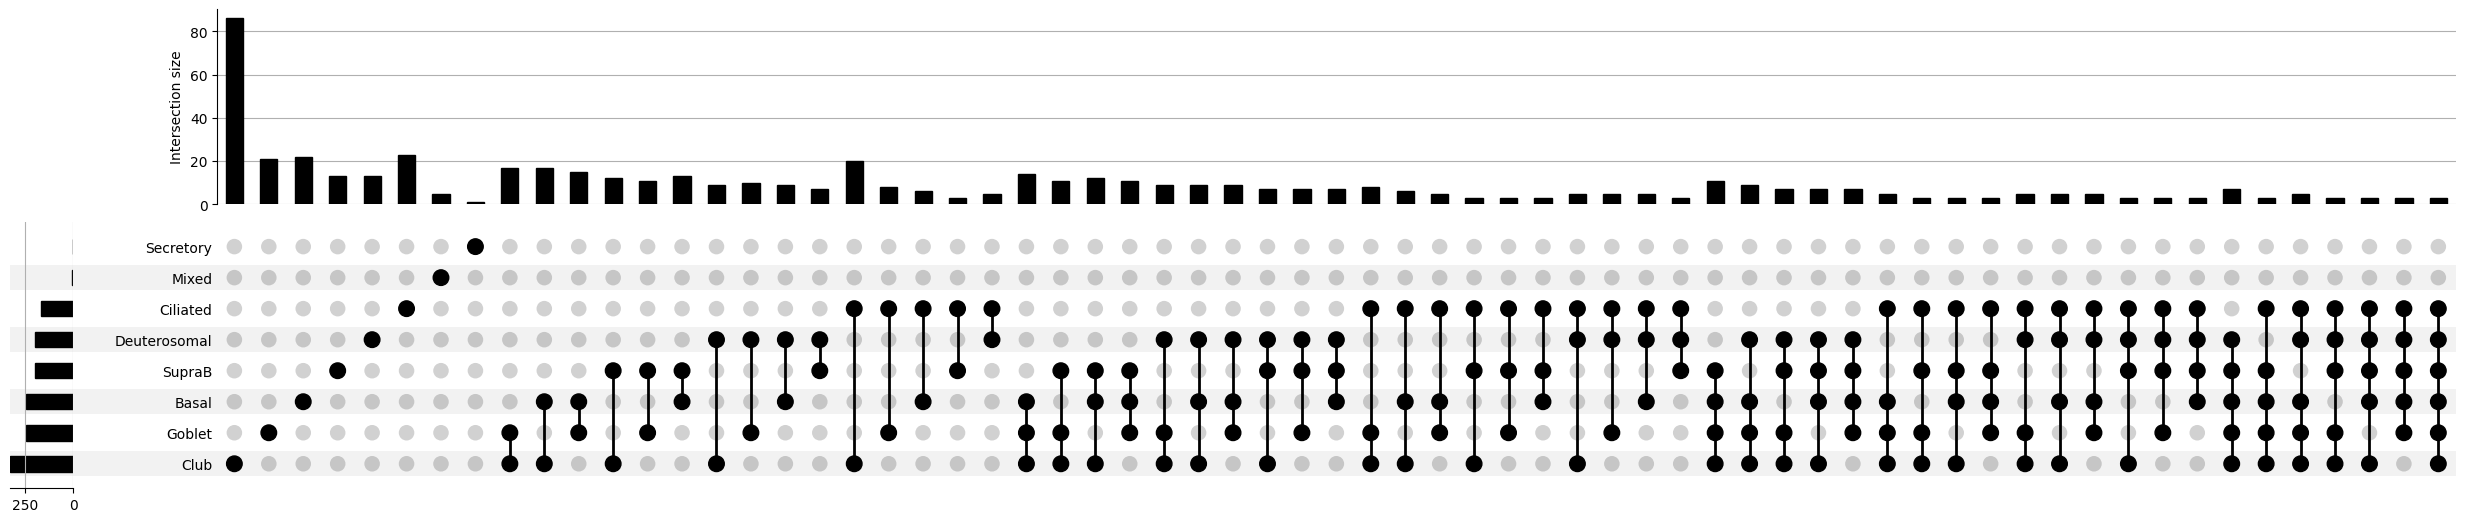

In [106]:
upsetplot.plot(example)

In [107]:
example

Basal  Ciliated  Club   Deuterosomal  Goblet  Mixed  Secretory  SupraB
False  False     False  False         True    False  False      False     21
                                      False   True   False      False      5
                                              False  True       False      1
                                                     False      True      13
                 True   False         False   False  False      False     86
                                                                          ..
       True      True   True          True    False  False      True       3
True   True      False  True          True    False  False      True       3
                 True   True          True    False  False      False      5
                                      False   False  False      True       3
                                      True    False  False      True       3
Length: 65, dtype: int64

In [108]:
test

[(('Goblet',), 21),
 (('Mixed',), 5),
 (('Secretory',), 1),
 (('SupraB',), 13),
 (('Club',), 86),
 (('Basal',), 22),
 (('Ionocyte',), 0),
 (('Deuterosomal',), 13),
 (('Ciliated',), 23),
 (('Goblet', 'Mixed'), 0),
 (('Goblet', 'Secretory'), 0),
 (('Goblet', 'SupraB'), 11),
 (('Goblet', 'Club'), 17),
 (('Goblet', 'Basal'), 15),
 (('Goblet', 'Ionocyte'), 0),
 (('Goblet', 'Deuterosomal'), 10),
 (('Goblet', 'Ciliated'), 8),
 (('Mixed', 'Secretory'), 0),
 (('Mixed', 'SupraB'), 0),
 (('Mixed', 'Club'), 0),
 (('Mixed', 'Basal'), 0),
 (('Mixed', 'Ionocyte'), 0),
 (('Mixed', 'Deuterosomal'), 0),
 (('Mixed', 'Ciliated'), 0),
 (('Secretory', 'SupraB'), 0),
 (('Secretory', 'Club'), 0),
 (('Secretory', 'Basal'), 0),
 (('Secretory', 'Ionocyte'), 0),
 (('Secretory', 'Deuterosomal'), 0),
 (('Secretory', 'Ciliated'), 0),
 (('SupraB', 'Club'), 12),
 (('SupraB', 'Basal'), 13),
 (('SupraB', 'Ionocyte'), 0),
 (('SupraB', 'Deuterosomal'), 7),
 (('SupraB', 'Ciliated'), 3),
 (('Club', 'Basal'), 17),
 (('Club',